In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime, timedelta
set_style("whitegrid")
import warnings

In [2]:
nikkei=pd.read_csv('data/nikkei_225_data.csv')

In [3]:
nikkei.head()

,Date,datetime,Open,High,Low,Close
0,1985-03-25,1985-03-25,12526.09,12535.10,12479.03,12493.26
1,1985-03-26,1985-03-26,12473.34,12486.15,12448.10,12486.15
2,1985-03-27,1985-03-27,12484.46,12551.77,12483.50,12550.82
3,1985-03-28,1985-03-28,12595.35,12611.17,12575.90,12604.02
4,1985-03-29,1985-03-29,12613.27,12622.62,12567.32,12580.76


In [6]:
def custom_time_indexing(df, date_column):
    """
    Function to reindex a DataFrame with a custom index that reflects gaps in a time series,
    while keeping the original date column for plotting, without modifying the original DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    date_column (str): Name of the column containing datetime objects.

    Returns:
    pd.DataFrame: A new DataFrame with the custom index reflecting date gaps,
                  while retaining the original dates in a new column.
    list: A list of the original date labels corresponding to valid data rows.
    """
    # Work on a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Ensure the date_column is of datetime type
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])

    # Set the date column as the index
    df_copy.set_index(date_column, inplace=True)

    # Generate the full date range (including missing dates)
    full_range = pd.date_range(start=df_copy.index.min(), end=df_copy.index.max())

    # Reindex the DataFrame to include the full range of dates
    df_reindexed = df_copy.reindex(full_range)

    # Create a custom index that increments by 1, but jumps when there are missing dates
    custom_index = []
    current_index = 1

    for i in range(len(df_reindexed)):
        if i == 0:
            custom_index.append(current_index)
        else:
            # Check if the current date is consecutive to the previous one
            if df_reindexed.index[i] - df_reindexed.index[i-1] > timedelta(days=1):
                # Increase the custom index by the actual day difference
                current_index += (df_reindexed.index[i] - df_reindexed.index[i-1]).days
            else:
                current_index += 1
            custom_index.append(current_index)

    # Assign the custom index to the DataFrame
    df_reindexed['custom_index'] = custom_index

    # Drop the rows where there are missing values
    df_final = df_reindexed.dropna()

    # Add the original date index as a new column and make it a datetime object
    df_final['date_time'] = df_final.index
    df_final['date_time']=df_final['date_time'].apply(lambda day: day.date())

    # Set the new custom index
    df_final.set_index('custom_index', inplace=True)

    # Return the final DataFrame and the valid original dates
    return df_final, df_final['date_time']


In [7]:
def linspace_dates(df,num_ticks):
    # because of missing dates, we have to do some annoying stuff there are about 14000 days between the first
    # and last day for UNP but some dates are skipped and so we have only 9400 or so datapoints
    # to properly plot, we will get some evenly spaced segments and then get the correct corresponding days

    start_date = df.loc[1]['date_time']
    end_date = df.tail(1)['date_time']
    
    # Calculate the total number of days in the range
    total_days = (end_date - start_date).values[0].days

    # Number of segments
    num_segments = num_ticks-1 # one less than the number of ticks desired

    # Calculate the length of each segment in days
    segment_length = total_days / num_segments

    # Create a list to hold the tick mark dates
    tick_dates = []

    # Calculate the dates for each tick mark
    for i in range(num_segments + 1):
        tick_date = start_date + timedelta(days=segment_length * i)
        tick_dates.append(tick_date)

    # Convert tick_dates to a list of strings for labeling
    tick_labels = [date.strftime('%Y-%m-%d') for date in tick_dates]

    # return the tick dates and labels
    return tick_dates, tick_labels


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Ignore all warnings
    nikkei_reindex,valid_dates = custom_time_indexing(nikkei, 'datetime')

In [9]:
nikkei_tick_dates, nikkei_tick_labels = linspace_dates(nikkei_reindex,10) 
# remember, the labels begin and end on the dates where we have available data for WFC

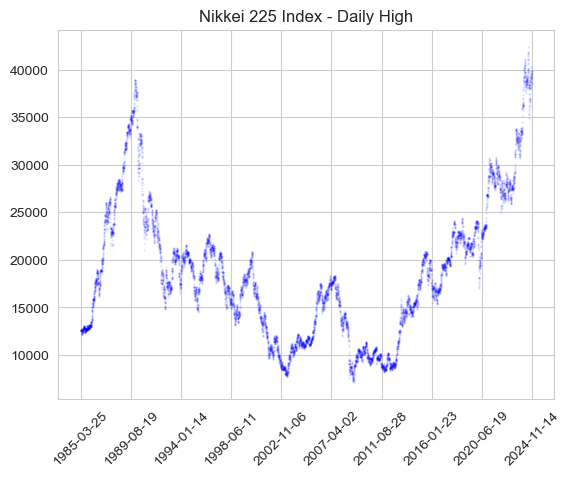

In [14]:
# we can plot Nikkei 225 now with the missing dates, it seems to know to plot the years on the x-axis now
# the issue is that it's not correctly spaced; the skips in time might not always be the same amount
#plt.plot(df_UNP.index,df_UNP['high'],label='Union Pacific - transportation',alpha=0.4)

plt.scatter(nikkei_reindex.index,nikkei_reindex['High'],label='High',color='b',alpha=0.1,s=0.4)

plt.title('Nikkei 225 Index - Daily High')

num_entries = nikkei_reindex.index.max()

# Set a desired number of ticks; in the cell above, we had num_segments = 9 (one less than num_ticks)
num_ticks = 10

# Generate equally spaced tick positions
nikkei_tick_positions = np.linspace(0, num_entries - 1, num_ticks).astype(int)

# Set the ticks and their corresponding labels from the original dates
plt.xticks(ticks=nikkei_tick_positions, labels=nikkei_tick_labels, rotation=45)

# Set x-axis limits to span the full range of the custom index
#plt.xlim(df_UNP_reindex.index.min(), df_UNP_reindex.index.max())

#plt.legend()
plt.show()

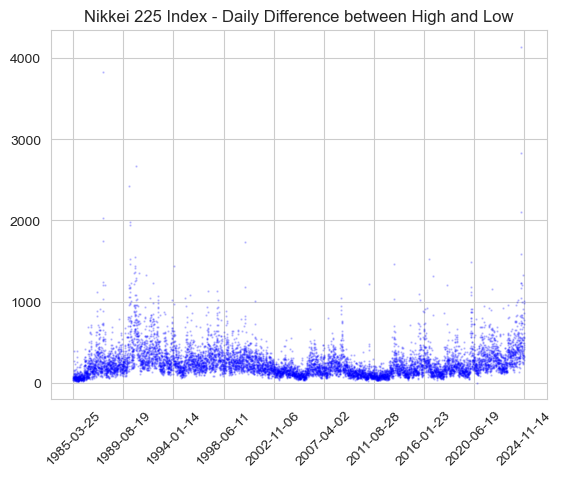

In [16]:
# we can plot Nikkei 225 now with the missing dates, it seems to know to plot the years on the x-axis now
# the issue is that it's not correctly spaced; the skips in time might not always be the same amount

plt.scatter(nikkei_reindex.index,nikkei_reindex['High']-nikkei_reindex['Low'],label='Difference',color='b',alpha=0.2,s=0.5)

plt.title('Nikkei 225 Index - Daily Difference between High and Low')

num_entries = nikkei_reindex.index.max()

# Set a desired number of ticks; in the cell above, we had num_segments = 9 (one less than num_ticks)
num_ticks = 10

# Generate equally spaced tick positions
nikkei_tick_positions = np.linspace(0, num_entries - 1, num_ticks).astype(int)

# Set the ticks and their corresponding labels from the original dates
plt.xticks(ticks=nikkei_tick_positions, labels=nikkei_tick_labels, rotation=45)


#plt.legend()
plt.show()